In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from nltk.lm import Vocabulary
from tqdm import tqdm
from functools import reduce

In [2]:
opus = pd.read_pickle("../data/raw/opus_sentences.pkl")
print(opus.shape)
opus.head()

(108017, 3)


,file,order,text
0,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,0,Source: librosgratis.liblit.com/
1,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,1,LAS AVENTURAS DE SHERLOCK HOLMES
2,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,2,Arthur Conan Doyle
3,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,3,1.
4,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,4,Escándalo en Bohemia


In [3]:
vocabulary = set("".join(opus["text"].to_list()))

In [4]:
char_to_ix = {k:i for i, k in enumerate(vocabulary, 3)}
char_to_ix["<pad>"] = 0
char_to_ix["<bos>"] = 1
char_to_ix["<eos>"] = 2
len(char_to_ix)

136

In [5]:
ix_to_char = {char_to_ix[k]:k for k in char_to_ix.keys()}

# generate training data

In [6]:
def text_to_ix(text):
    return [1] + [char_to_ix[c] for c in text] + [2]

In [7]:
def ix_to_text(ixs):
    return "".join([ix_to_char[i] for i in ixs])

In [8]:
def pad(x, l):
    if len(x) < l:
        #print(x)
        return x + [0 for i in range(l - len(x))]
    else:
        return x[:l-1] + [2]
    
len(pad(list(range(25)), 25))

25

In [9]:
letters = list(sorted(vocabulary))

def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0,1,1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0,1,1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i+1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                #print(char_to_ix[random_letter])
                noisy_sentence.append(random_letter)
                #noisy_sentence.append(char_to_ix[random_letter])
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass     
        i += 1
    #return noisy_sentence
    return "".join(noisy_sentence)

noise_maker("Relocate, remove, or add characters to create spelling mistakes", 0.97)

'Relocate, remove, or add characters to create spelling mistakes'

In [10]:
from timeit import default_timer

In [11]:
opus["text"].map(len).describe(percentiles = np.arange(0, 1, 0.1))

count    108017.000000
mean        108.709648
std          98.915442
min           1.000000
0%            1.000000
10%          22.000000
20%          35.000000
30%          49.000000
40%          65.000000
50%          83.000000
60%         103.000000
70%         129.000000
80%         163.000000
90%         222.000000
max        2249.000000
Name: text, dtype: float64

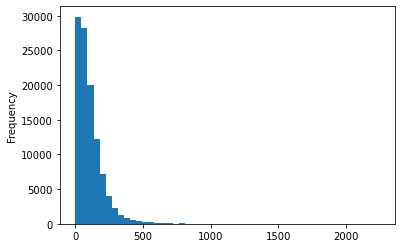

In [12]:
opus["text"].map(len).plot.hist(bins = 50)

In [13]:
noise_examples = 5
threshold = 0.95
sample_size = 2
padding = 25

start = default_timer()

preprocess = pd.DataFrame(opus["text"].sample(n = sample_size))\
.assign(noisy_sentences = lambda df: df["text"].map(lambda x:  [x] * 5 \
                                                    + [noise_maker(x, threshold) 
                                                       for i in range(noise_examples)]))\
.explode("noisy_sentences")\
.assign(X = lambda df: df["noisy_sentences"]\
        .map(text_to_ix)\
        .map(lambda x: pad(x, 
                           padding)),
        Y = lambda df: df["text"]\
        .map(text_to_ix)\
        .map(lambda x: pad(x, 
                           padding)))\
.reset_index(drop = True)

print(default_timer() - start)

print(preprocess.shape)
preprocess.head(50)

0.038024928006052505
(20, 4)


,text,noisy_sentences,X,Y
0,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué hacer ni qué decir, y antes de qu...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."
1,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué hacer ni qué decir, y antes de qu...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."
2,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué hacer ni qué decir, y antes de qu...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."
3,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué hacer ni qué decir, y antes de qu...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."
4,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué hacer ni qué decir, y antes de qu...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."
5,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué hcer ni qué decir, y antes de que...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."
6,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué hacer ni qué decir, y antes de qu...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."
7,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué hacer ni qué decir, y antes deq u...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."
8,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué haceDr ni qué decir, y nates de q...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."
9,"No sabía qué hacer ni qué decir, y antes de qu...","No sabía qué hcer ni qué deci, y antes deÌ que...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7...","[1, 27, 125, 69, 34, 5, 127, 15, 5, 69, 112, 7..."


In [14]:
preprocess["X"].map(len).describe()

count    20.0
mean     25.0
std       0.0
min      25.0
25%      25.0
50%      25.0
75%      25.0
max      25.0
Name: X, dtype: float64

In [15]:
preprocess["Y"].map(len).describe()

count    20.0
mean     25.0
std       0.0
min      25.0
25%      25.0
50%      25.0
75%      25.0
max      25.0
Name: Y, dtype: float64

In [16]:
X = torch.stack(preprocess["X"].map(torch.tensor).to_list())
X.shape

torch.Size([20, 25])

In [17]:
Y = torch.stack(preprocess["Y"].map(torch.tensor).to_list())
Y.shape

torch.Size([20, 25])

# model

100%|██████████| 500/500 [00:18<00:00, 26.37it/s]


final loss: 0.02275429479777813


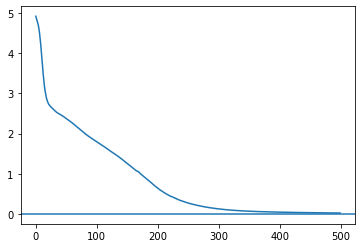

<bos>A falta de las maravill<eos>
<bos>""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


'<bos>A falta de las maravill<eos>'

In [45]:
class CharLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocabulary_size, layers):
        super(CharLSTM, self).__init__()
        self.embeddings = nn.Embedding(vocabulary_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, layers)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim, layers)
        self.decoder_to_vocabulary = nn.Linear(hidden_dim, vocabulary_size)
        self.vocabulary_size = vocabulary_size
    
    def forward(self, sentence, current_token):
        embeddings = self.embeddings(sentence).transpose(0, 1)
        sequence, hidden = self.encoder(embeddings)
        current_token_embeddings = self.embeddings(current_token).transpose(0, 1)
        chars, final_hidden = self.decoder(current_token_embeddings, hidden)
        chars = self.decoder_to_vocabulary(chars).transpose(0, 1)
        return chars.log_softmax(-1), final_hidden
    
    def fit(self, X, Y, lr = 0.1, epochs = 20):
        loss_function = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr)
        losses = []
        for i in tqdm(range(epochs)):
            outputs, last_hidden = self(X, Y[:, :-1])
            outputs = outputs.transpose(1, 2).squeeze()
            loss = loss_function(outputs, Y[:, 1:])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        print("final loss:", losses[-1])
        plt.axhline(0)
        plt.plot(losses)
        plt.show()
        
    def spellcheck(self, sentence, max_length = 400):
        sentence = sentence.replace("<bos>", "").replace("<eos>", "").replace("<pad>", "")
        sentence = torch.tensor(text_to_ix(sentence))
        sentence_embeddings = self.embeddings(sentence).unsqueeze(1)
        sequence, hidden = self.encoder(sentence_embeddings)
        output = [1]
        for i in range(max_length):
            current_token = self.embeddings(torch.tensor([output[-1]])).unsqueeze(1)
            next_token, hidden = self.decoder(current_token, hidden)
            next_token = self.decoder_to_vocabulary(next_token).argmax(-1).item()
            output.append(next_token)
            if next_token == 2 or next_token == 0:
                break
        return ix_to_text(output)

    
n = 16
net = CharLSTM(n, n, len(char_to_ix), 2)
test_string = ix_to_text(X[10].tolist())
before_training = net.spellcheck(test_string)
net.fit(X, Y, epochs = 500, lr = 0.01)


print(test_string)
print(before_training)
net.spellcheck(test_string)

In [46]:
net.spellcheck("<bos>A falta de lajfkdjfs maravilfdsafsdfasl<eos>")

'<bos>A falta de las maravill<eos>'

In [52]:
n = 128
net = CharLSTM(n, n, len(char_to_ix), 1)
net.spellcheck(test_string)

'<bos>vbÌuEJsíEJsY*ÌEJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«ôÌO)EJsO*iDD«'

In [20]:
example = 11
print(ix_to_text(X[:example][-1].tolist()))

print(ix_to_text(net(X[:example], Y[:example]).argmax(2)[-1].tolist()))

<bos>A falta de las maravill<eos>


AttributeError: 'tuple' object has no attribute 'argmax'

In [ ]:
text_to_ix??